Installation du pytorch géometrique

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 


Intsall ogb

In [ ]:
!pip install ogb

Data loaders

Importation des libraries 

In [ ]:
import torch
import torch_geometric
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

Pytorch Geometric Loader

In [ ]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

dataset = PygNodePropPredDataset(name = 'ogbn-arxiv',transform=T.ToSparseTensor()) 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:02<00:00, 32.85it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 8208.03it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2146.52it/s]

Saving...



Done!


In [ ]:
# dataset exploration
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(100*'=')

data = dataset[0]  

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {len(train_idx)}')
print(f'Training node label rate: {len(train_idx) / (len(train_idx)+len(valid_idx)+len(test_idx))}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 128
Number of classes: 40
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])
Number of nodes: 169343
Number of edges: 1166243
Number of training nodes: 90941
Training node label rate: 0.5370224928104498
Is undirected: False


In [ ]:
# definir le device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [ ]:
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
data = data.to(device)
data.adj_t = data.adj_t.to(device)
data.x = data.x.to(device)
data

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])

Model1

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, 16, cached=True)
    self.conv2 = GCNConv(16, dataset.num_classes, cached=True)

  def forward(self, x, adj_t):
    x = self.conv1(x, adj_t)
    x = F.relu(x)
    x = self.conv2(x, adj_t)
    return F.log_softmax(x, dim=1)

model_1 = GNN()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)

def train(data):
    model_1.train()
    optimizer.zero_grad()
    out = model_1(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()
    return float(loss)

# for epoch in range(1, 201):
#     loss = train(data)

model_1

GNN(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 40)
)

Entrainement du modele

In [ ]:
model_1 = model_1.to(device)
losses = []
for epoch in range(0, 601):
    loss = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 3.7392
Epoch: 100, Loss: 1.6109
Epoch: 200, Loss: 1.2791
Epoch: 300, Loss: 1.2018
Epoch: 400, Loss: 1.1713
Epoch: 500, Loss: 1.1549
Epoch: 600, Loss: 1.1446


Visualisation de l'erreur

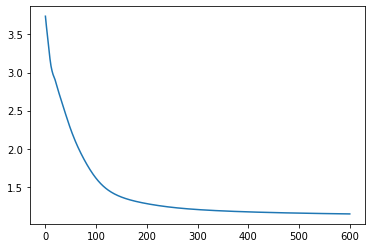

In [ ]:
from matplotlib.pyplot import title
import seaborn as sns
losses_float = [loss for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x = loss_indices, y = losses_float)
plt

In [ ]:
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    # update the evaluator
    train_acc = evaluator.eval({'y_true': data.y[split_idx['train']],
                                'y_pred': y_pred[split_idx['train']],
                               })['acc']
    valid_acc = evaluator.eval({'y_true': data.y[split_idx['valid']],
                                'y_pred': y_pred[split_idx['valid']],
                               })['acc']
    test_acc = evaluator.eval({'y_true': data.y[split_idx['test']],
                               'y_pred': y_pred[split_idx['test']],
                              })['acc']

    return train_acc, valid_acc, test_acc

In [ ]:
evaluator = Evaluator(name='ogbn-arxiv')
evaluator

In [ ]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
# for epoch in range(1, 1 + epoch):
    # loss = train(model, data, train_idx, optimizer)
result = test(model_1, data, split_idx, evaluator)

    # if epoch % epoch == 0:
train_acc, valid_acc, test_acc = result
print(f'Epoch: {epoch:02d}, '
      f'Loss: {loss:.4f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 600, Loss: 1.1446, Train: 66.45%, Valid: 67.06% Test: 66.18%


Model_2

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv,SAGEConv
import torch_geometric.transforms as T


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, 256, cached=True)
    self.bns = torch.nn.BatchNorm1d(256)
    self.conv2 = GCNConv(256, 128, cached=True)
    self.conv3 = SAGEConv(128, dataset.num_classes, cached=True)

  def forward(self, x, adj_t):
    x = self.conv1(x, adj_t)
    x = self.bns(x)
    x = self.conv2(x, adj_t)
    x = F.relu(x)
    x = self.conv3(x, adj_t)
    x = F.dropout(x, p=0.5, training=self.training)
    return F.log_softmax(x, dim=1)

model_2 = GNN()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

def train(data):
    model_2.train()
    optimizer.zero_grad()
    out = model_2(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()
    return float(loss)

# for epoch in range(1, 201):
#     loss = train(data)

model_2

GNN(
  (conv1): GCNConv(128, 256)
  (bns): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(256, 128)
  (conv3): SAGEConv(128, 40, aggr=mean)
)

In [ ]:
#avec Sage2
model_2 = model_2.to(device)
losses = []
for epoch in range(0, 601):
    loss = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 4.0416
Epoch: 100, Loss: 2.1540
Epoch: 200, Loss: 2.0761
Epoch: 300, Loss: 2.0444
Epoch: 400, Loss: 2.0248
Epoch: 500, Loss: 1.9994
Epoch: 600, Loss: 2.0044


In [ ]:
evaluator = Evaluator(name='ogbn-arxiv')

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
# for epoch in range(1, 1 + epoch):
    # loss = train(model, data, train_idx, optimizer)
result = test(model_2, data, split_idx, evaluator)

    # if epoch % epoch == 0:
train_acc, valid_acc, test_acc = result
print(f'Epoch: {epoch:02d}, '
      f'Loss: {loss:.4f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 600, Loss: 2.1405, Train: 77.68%, Valid: 70.57% Test: 70.00%


Model_3

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv,SAGEConv
import torch_geometric.transforms as T


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = SAGEConv(dataset.num_features, 256, cached=True)
    self.bns1 = torch.nn.BatchNorm1d(256)
    self.conv2 = SAGEConv(256, 128, cached=True)
    self.bns2 = torch.nn.BatchNorm1d(128)
    self.conv3 = SAGEConv(128, dataset.num_classes, cached=True)

  def forward(self, x, adj_t):
    x = self.conv1(x, adj_t)
    x = self.bns1(x)
    x = self.conv2(x, adj_t)
    x = self.bns2(x)
    x = F.relu(x)
    x = self.conv3(x, adj_t)
    x = F.dropout(x, p=0.5, training=self.training)
    return F.log_softmax(x, dim=1)

model_3 = GNN()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)

def train(data):
    model_3.train()
    optimizer.zero_grad()
    out = model_3(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()
    return float(loss)

# for epoch in range(1, 201):
#     loss = train(data)

model_3

GNN(
  (conv1): SAGEConv(128, 256, aggr=mean)
  (bns1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(256, 128, aggr=mean)
  (bns2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SAGEConv(128, 40, aggr=mean)
)

In [ ]:
model_3 = model_3.to(device)
losses = []
for epoch in range(0, 601):
    loss = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 4.0011
Epoch: 100, Loss: 2.1547
Epoch: 200, Loss: 2.0652
Epoch: 300, Loss: 1.9878
Epoch: 400, Loss: 1.9190
Epoch: 500, Loss: 1.8881
Epoch: 600, Loss: 1.8539


In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
# for epoch in range(1, 1 + epoch):
    # loss = train(model, data, train_idx, optimizer)
result = test(model_3, data, split_idx, evaluator)

    # if epoch % epoch == 0:
train_acc, valid_acc, test_acc = result
print(f'Epoch: {epoch:02d}, '
      f'Loss: {loss:.4f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 600, Loss: 1.8539, Train: 85.66%, Valid: 67.60% Test: 67.07%


Model_4

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv,SAGEConv, GATConv
import torch_geometric.transforms as T


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, 256, cached=True)
    self.bns1 = torch.nn.BatchNorm1d(256)
    self.conv2 = GATConv(256, 128, cached=True)
    self.bns2 = torch.nn.BatchNorm1d(128)
    self.conv3 = GCNConv(128, dataset.num_classes, cached=True)

  def forward(self, x, adj_t):
    x = self.conv1(x, adj_t)
    x = self.bns1(x)
    x = self.conv2(x, adj_t)
    # x = self.bns2(x)
    x = F.relu(x)
    x = self.conv3(x, adj_t)
    x = F.dropout(x, p=0.5, training=self.training)
    return F.log_softmax(x, dim=1)

model_4 = GNN()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.01)

def train(data):
    model_4.train()
    optimizer.zero_grad()
    out = model_4(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()
    return float(loss)

# for epoch in range(1, 201):
#     loss = train(data)

model_4

GNN(
  (conv1): GCNConv(128, 256)
  (bns1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(256, 128, heads=1)
  (bns2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(128, 40)
)

In [ ]:
model_4 = model_4.to(device)
losses = []
for epoch in range(0, 601):
    loss = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 16.6485
Epoch: 100, Loss: 2.3334
Epoch: 200, Loss: 2.2442
Epoch: 300, Loss: 2.2643
Epoch: 400, Loss: 2.1756
Epoch: 500, Loss: 2.1523
Epoch: 600, Loss: 2.1405


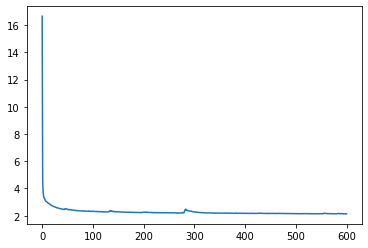

In [ ]:
from matplotlib.pyplot import title
import seaborn as sns
losses_float = [loss for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x = loss_indices, y = losses_float)
plt

In [ ]:
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
# for epoch in range(1, 1 + epoch):
    # loss = train(model, data, train_idx, optimizer)
result = test(model_4, data, split_idx, evaluator)

    # if epoch % epoch == 0:
train_acc, valid_acc, test_acc = result
print(f'Epoch: {epoch:02d}, '
      f'Loss: {loss:.4f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 600, Loss: 2.1405, Train: 73.61%, Valid: 71.26% Test: 70.25%


Model_5

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv,SAGEConv, GATConv
import torch_geometric.transforms as T


class GNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GATConv(dataset.num_features, 256, cached=True)
    self.bns1 = torch.nn.BatchNorm1d(256)
    self.conv2 = GATConv(256, 128, cached=True)
    self.bns2 = torch.nn.BatchNorm1d(128)
    self.conv3 = GATConv(128, dataset.num_classes, cached=True)

  def forward(self, x, adj_t):
    x = self.conv1(x, adj_t)
    x = self.bns1(x)
    x = self.conv2(x, adj_t)
    # x = self.bns2(x)
    x = F.relu(x)
    x = self.conv3(x, adj_t)
    x = F.dropout(x, p=0.5, training=self.training)
    return F.log_softmax(x, dim=1)

model_5 = GNN()
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)

def train(data):
    model_5.train()
    optimizer.zero_grad()
    out = model_5(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()
    return float(loss)

# for epoch in range(1, 201):
#     loss = train(data)

model_5

GNN(
  (conv1): GATConv(128, 256, heads=1)
  (bns1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(256, 128, heads=1)
  (bns2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 40, heads=1)
)

In [ ]:
model_5 = model_5.to(device)
losses = []
for epoch in range(0, 601):
    loss = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 4.4534
Epoch: 100, Loss: 2.1554
Epoch: 200, Loss: 2.0953
Epoch: 300, Loss: 2.0642
Epoch: 400, Loss: 2.0377
Epoch: 500, Loss: 2.0331
Epoch: 600, Loss: 2.0142


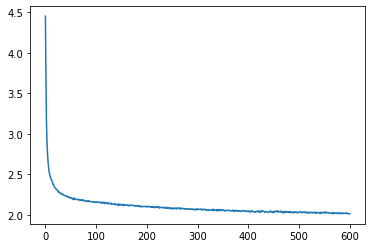

In [ ]:
from matplotlib.pyplot import title
import seaborn as sns
losses_float = [loss for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x = loss_indices, y = losses_float)
plt

In [ ]:
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.001)
# for epoch in range(1, 1 + epoch):
    # loss = train(model, data, train_idx, optimizer)
result = test(model_5, data, split_idx, evaluator)

    # if epoch % epoch == 0:
train_acc, valid_acc, test_acc = result
print(f'Epoch: {epoch:02d}, '
      f'Loss: {loss:.4f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 600, Loss: 2.0142, Train: 77.97%, Valid: 70.42% Test: 70.04%


GAT prend presque 3* plus de temps qu'un GCN

**Deux couches gcnconv:**

Epoch: 600, Loss: 1.1446, Train: 66.45%, Valid: 67.06% Test: 66.18%

**Deux couches GCNConv et une couche SAGECon:**

Epoch: 600, Loss: 2.1405, Train: 77.68%, Valid: 70.57% Test: 70.00%

**Trois couches SAGEConv:**

Epoch: 600, Loss: 1.8539, Train: 85.66%, Valid: 67.60% Test: 67.07%

**Deux couches GCNConv et une couche GATConv  avec des batch normalization:**

Epoch: 600, Loss: 2.1405, Train: 73.61%, Valid: 71.26% Test: 70.25%

**Trois couches de GAT avec des batchnorm1d:**

Epoch: 600, Loss: 2.0142, Train: 77.97%, Valid: 70.42% Test: 70.04%